
Si tratta di un compito regressione, in cui l'obiettivo è prevedere l'area bruciata dagli incendi boschivi, nella regione nordorientale del Portogallo, utilizzando dati meteorologici e di altro tipo.
DATASET: Multivariato
AREA TEMATICA: Clima e Ambiente
(Basato su campionu reali)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluation


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from scipy.stats import boxcox

Import del dataset da file csv come dataframe usando pandas

In [4]:
pd.set_option('display.max_columns', None)

file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)

df_start = df.drop(columns=['day', 'month'])
df_start

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


La funzione df.describe() è un metodo molto utile di pandas, una libreria Python per l'elaborazione dei dati. Serve per generare statistiche descrittive di base per le colonne numeriche (o categoriali se specificato) di un DataFrame.

In [5]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Analizzando le statistiche si puo notare come la caratteristica rain ha una media molto piu bassa rispetto il massimo (<< della metà), lo stesso anche per l'output che sembra essere estremamente sbilanciata verso lo zero. una visualizzazione dei dati potrebbe aiutare a capire la distribuzione.

<Axes: xlabel='area', ylabel='Count'>

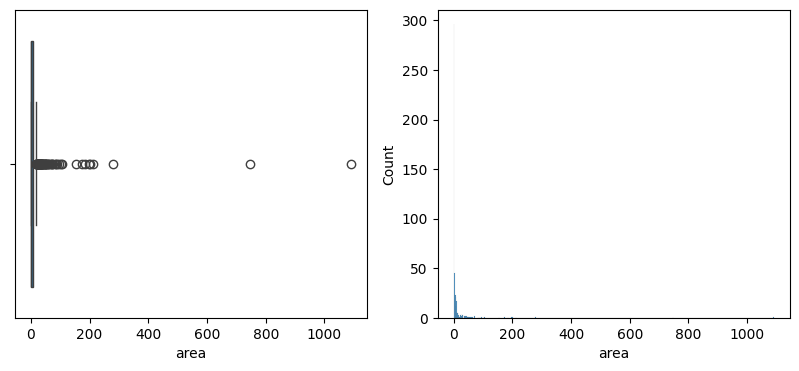

In [6]:

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['area'], kde = False)

Un modo per riportare l'area su una scala migliore è l'utilizzo del logaritmo. Questa tecnica, oltre che ridurre questo sbilanciamento dei dati potrebbe avere, come effetto collaterale, la capacità predittiva del modello.

<Axes: xlabel='log_area', ylabel='Count'>

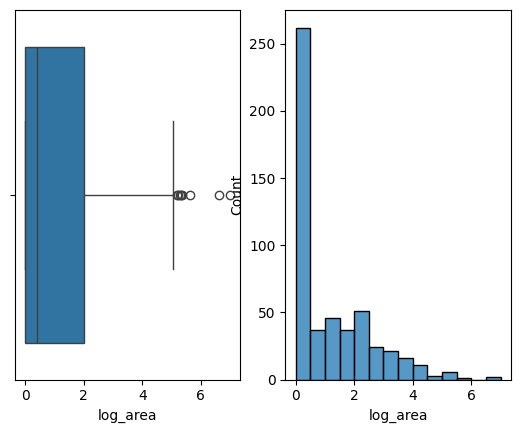

In [7]:
# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['log_area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['log_area'], kde = False)

Ora diamo un'occhiata anche alla variabile 'rain'

<Axes: xlabel='rain', ylabel='Count'>

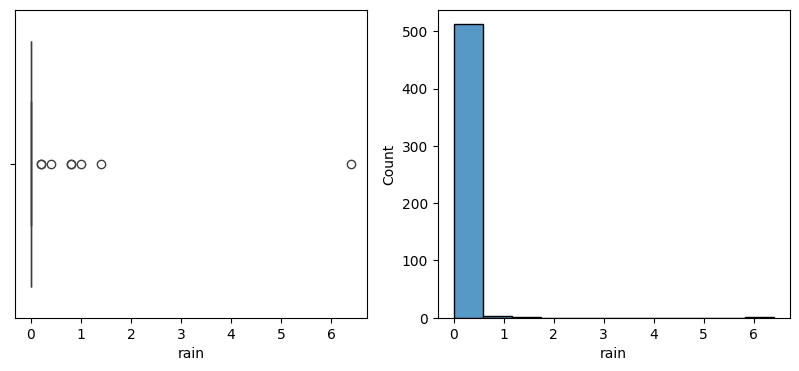

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['rain']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['rain'], kde = False)

Anche in questo caso i valori sono molto schiacciati verso lo zero... Si può provare anche qui un cambio di scala utilizzando il logaritmo ma non sarebbe opportuno, perchè i valori della pioggia sono fondamentali nell'apprendimento perchè sono una parte fondamentale nella previsione di incendi e il logaritmo ne riduce l'importanza (coerentemente a quanto detto non è opportuno rimuovore gli outliers) 

Ora riproponiamo dati per fare ulteriori analisi sulle variabili stringa

In [9]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000


Chiaramente i mesi e i giorni non sono caratteristiche numerice, quindi vanno codificate. Qui è possibile fare due considerazioni distinte: per i MESI possiamo adottare una codifica ciclica dato che sono essi stessi dei cicli, ma soprattutto generalmente esistono dei mesi piu caldi e piu freddi e questa relazione non è indipendente dai mesi; mentre pwr quanto riguarda i GIORNI si può pensare di utilizzare OneHotEncoding per non aggiungere ulteriori relazioni d'ordine al modello (in qaunto idealmente non necessarie per i giorni).

In [10]:
# CODIFICA MESI
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno


# CODIFICA GIORNI
enc_oneHot = preprocessing.OneHotEncoder()

arr = enc_oneHot.fit_transform(df[['day']]) 

# Conversione in array denso
dense_array = arr.toarray()
# Recuero nomi per le colonne
col_names = enc_oneHot.get_feature_names_out(['day'])
# Creazione DataFrame dalle colonne codificate da concatenare a quello originale
encoded_df = pd.DataFrame(dense_array, columns=col_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)

df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,month_encoded,month_encoded_sin,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000,3.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000,10.0,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000,10.0,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000,3.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000,3.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871,8.0,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592,8.0,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152,8.0,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000,8.0,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Un ulteriore passo è la pulizia del DataFrame per rimuovore le colonne che non verranno utilizzate durante l'addestramento

In [11]:
df.drop(columns=['day', 'month', 'area', 'month_encoded'], inplace=True)
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Prima di cercare un modello opportuno e addestrarlo analizzaimo le correlazioni tra le colonne del dataset. Le colonne sottoposte a oneHotEncoding, semplicemente, non verranno considerate, al fine di evitare eventuali correlazioni dovute dalla natura della codifica

<Axes: title={'center': 'Features Correlation'}>

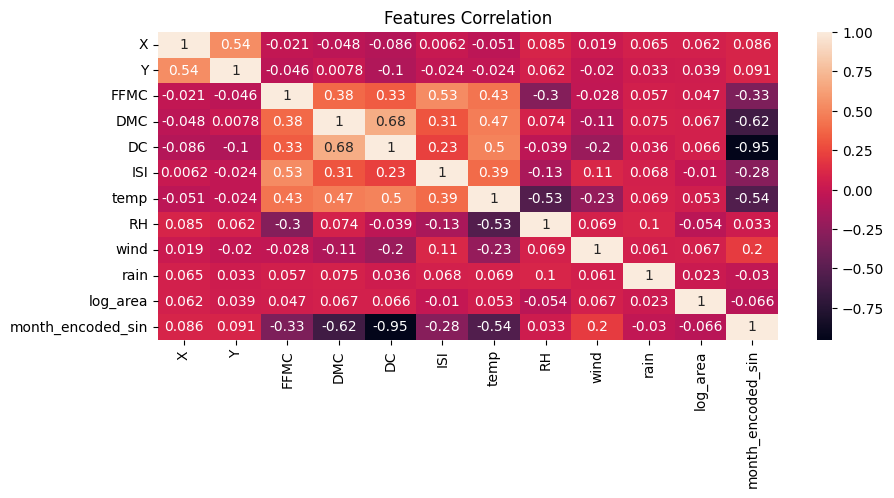

In [12]:
#df without theese two features (species and target)
df_corr = df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'])

plt.figure(figsize=(10,4))
plt.title('Features Correlation')

sns.heatmap(df_corr.corr(), annot=True) # Usa la correlazione di Pearson

Si può notare come il DC è molto correlato ai mesi dell'anno... c'era da aspettarselo vista la natura della caratteristica DC (vedere README).
Prima di effettuare ulteriori manipolazioni del dataset, però, proviamo ad addestrare qualche modello (verrà utilizzato l'argomento random state = 42 per la riproducibilità dei risultati nel confronto tra modelli).

1) Dopo vari test si è notato come l'accuratezzza dei modelli migliora rimuovendo i giorni dalle caratteristiche del dataset . Questo potrebbe esser dovuto dal fatto che i giorni non racchiudono informazioni necessarie per il task in questione, aggiungono solo rumore e aumento di complessità computazionale a causa dei calcoli sulla matrice sparsa. 

2) I vari modelli non riescono a fare previsione corrette, in quanto se troppo complessi overfittano, mentre quelli meno complessi non riescono a spiegara la varianza dei dati, introducendo underfit.
Una possibilità è quella di lavorare sugli outliers

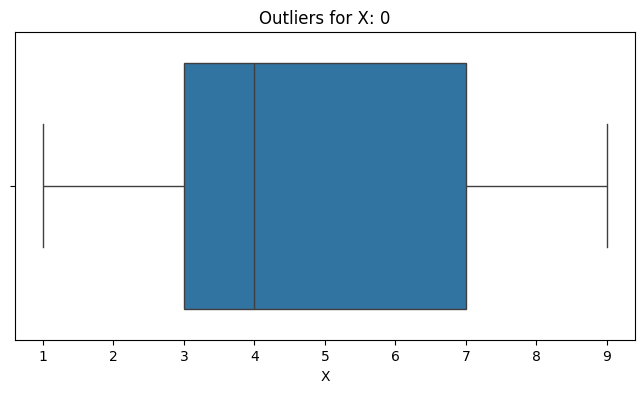

Colonna X: 0 outliers


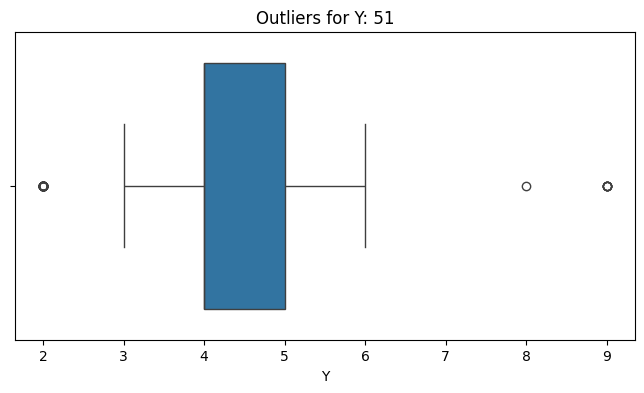

Colonna Y: 51 outliers


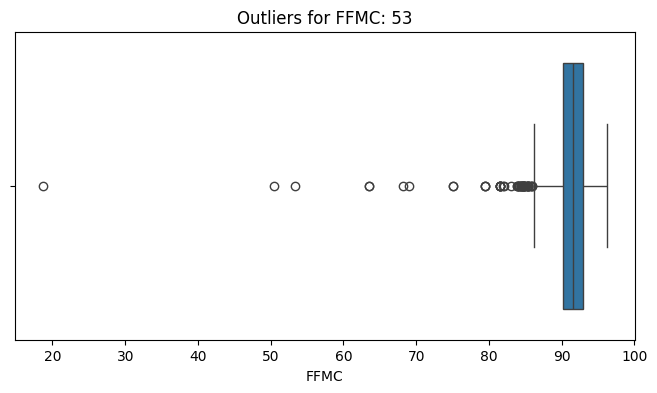

Colonna FFMC: 53 outliers


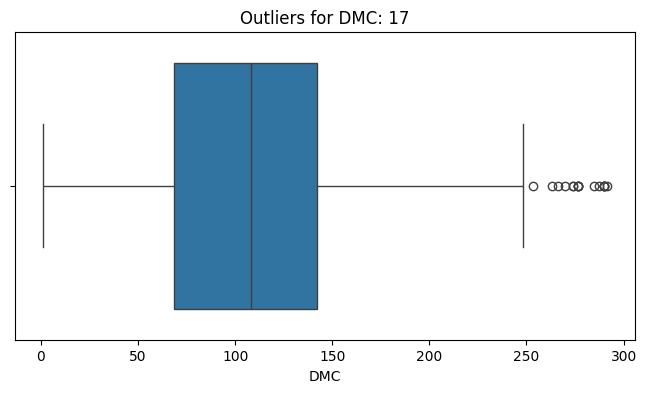

Colonna DMC: 17 outliers


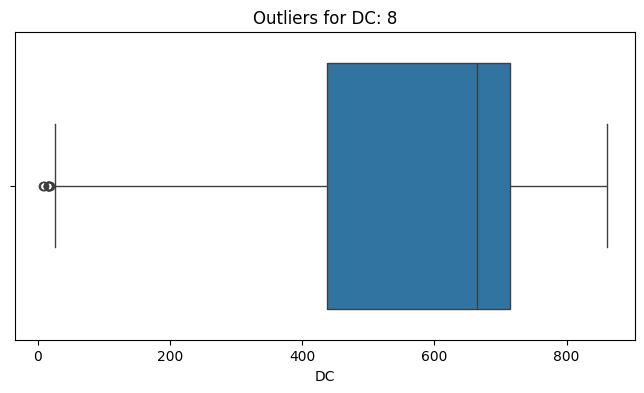

Colonna DC: 8 outliers


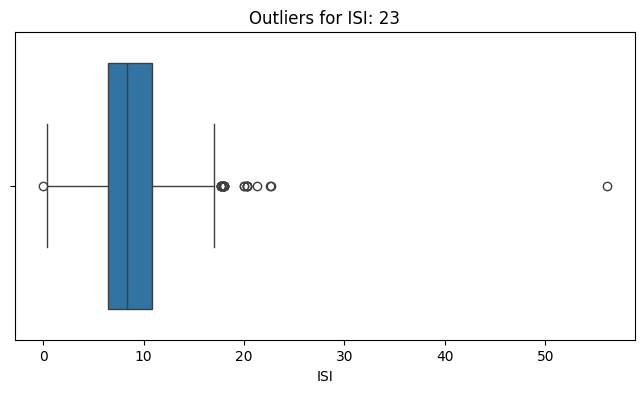

Colonna ISI: 23 outliers


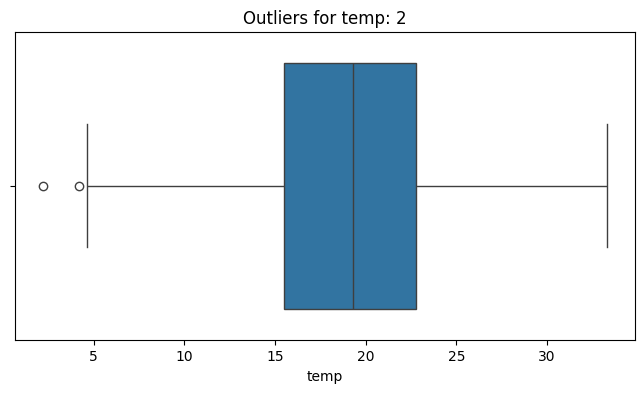

Colonna temp: 2 outliers


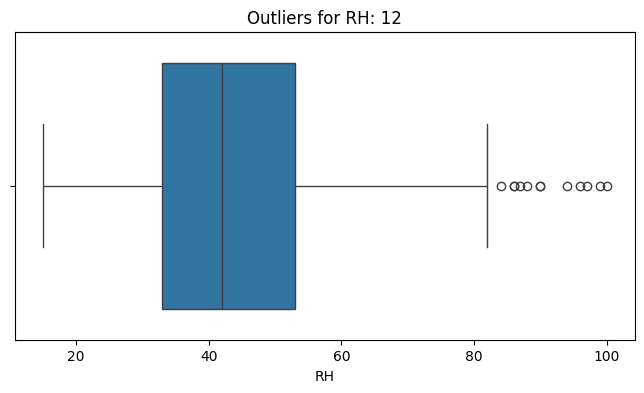

Colonna RH: 12 outliers


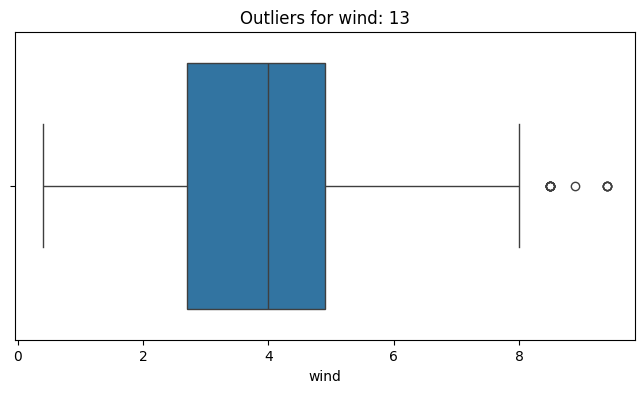

Colonna wind: 13 outliers


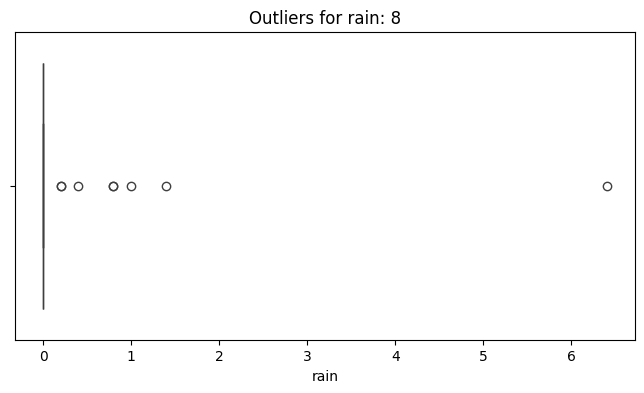

Colonna rain: 8 outliers


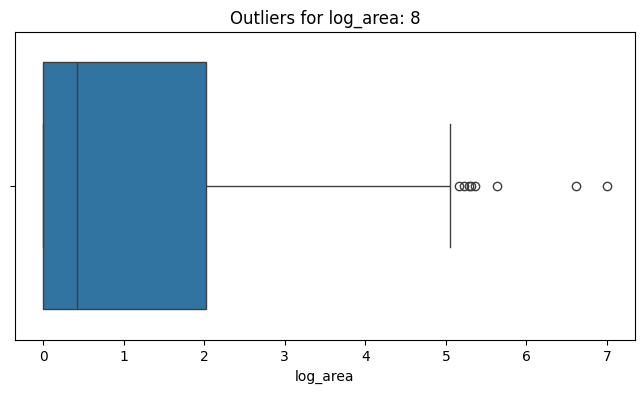

Colonna log_area: 8 outliers


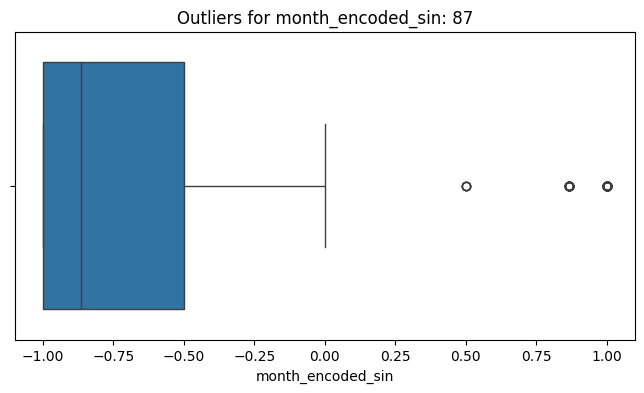

Colonna month_encoded_sin: 87 outliers


In [13]:
df_temp = df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'])
for col in df_temp.select_dtypes(include=['float', 'int']).columns:
    
    # Calcola i quartili Q1 e Q3 e l'IQR
    Q1 = df_temp[col].quantile(0.25)
    Q3 = df_temp[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definisci i limiti per gli outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtra gli outlier
    outliers = df_temp[(df_temp[col] < lower_bound) | (df_temp[col] > upper_bound)]
    
    # Conta il numero di outlier
    num_outliers = outliers.shape[0]
    
    # Visualizza il boxplot per la variabile
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_temp, x=col)
    plt.title(f'Outliers for {col}: {num_outliers}')
    plt.show()
    
    # Stampa il numero di outlier per la colonna
    print(f'Colonna {col}: {num_outliers} outliers')

In [14]:
# Sezione per verifiche sull'attendibilità degli outliers
outliers_ISI = df_temp[df_temp['ISI'] > 17]
outliers_temp = df_temp[df_temp['temp'] < 3]
outliers_FFMC = df_temp[df_temp['FFMC'] < 50]
outliers_DC = df_temp[df_temp['DC'] < 10]
outliers_log_area = df_temp[df_temp['log_area'] > 1]

print(len(outliers_log_area))
outliers_log_area

218


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
160,7,4,90.1,39.7,86.6,6.2,16.1,29,3.1,0.0,1.011601,1.000000
161,6,4,95.2,131.7,578.8,10.4,20.3,41,4.0,0.0,1.064711,-0.866025
162,6,3,90.6,50.1,100.4,7.8,15.2,31,8.5,0.0,1.078410,1.000000
163,8,6,92.5,121.1,674.4,8.6,17.8,56,1.8,0.0,1.081805,-1.000000
164,8,5,89.7,90.0,704.4,4.8,17.8,67,2.2,0.0,1.101940,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
505,1,2,91.0,163.2,744.4,10.1,26.7,35,1.8,0.0,1.916923,-0.866025
509,5,4,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,1.153732,-0.866025
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025


3) Rimozione outliers (df_clean):

- FFMC -> Valori < 50 potrebbero essere rari o anomali, ma sono generalmente non rappresentativi del comportamento tipico dei combustibili superficiali.
- DC -> valori < 0 sono da considere come errori nella valutazione.
- ISI presenta un outliers (> 50, estremamente raro) che  si puo supporre non rappresenti la natura dei dati, quindi puo essere escluso.
- log_area -> possiamo escludere valori di area molto grandi, concentrandoci su incendi piu piccoli.

In [15]:
# Copia del DataFrame originale, per non alterarlo direttamente
df_clean = df_temp.copy()

df_clean = df_clean[(df_clean['FFMC'] >= 50)]
df_clean = df_clean[(df_clean['DC'] > 0)]
df_clean = df_clean[(df_clean['ISI'] < 50)]
df_clean = df_clean[(df_clean['log_area'] < 5)]

print(f"Dimensione originale del DataFrame: {df_temp.shape}")
print(f"Dimensione del DataFrame senza outliers: {df_clean.shape}")

df_clean

Dimensione originale del DataFrame: (517, 12)
Dimensione del DataFrame senza outliers: (506, 12)


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152,-0.866025
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025


4) La rimozione degli outliers ha migliorato la R2 score (di poco), ma l'accuratezza continua ad essere scarsa. A questo punto si potrebbe provare ad ingegnerizzare le feature al fine di aumentare la correlazione tra le variabili in input con il target.

<Axes: title={'center': 'Features Correlation'}>

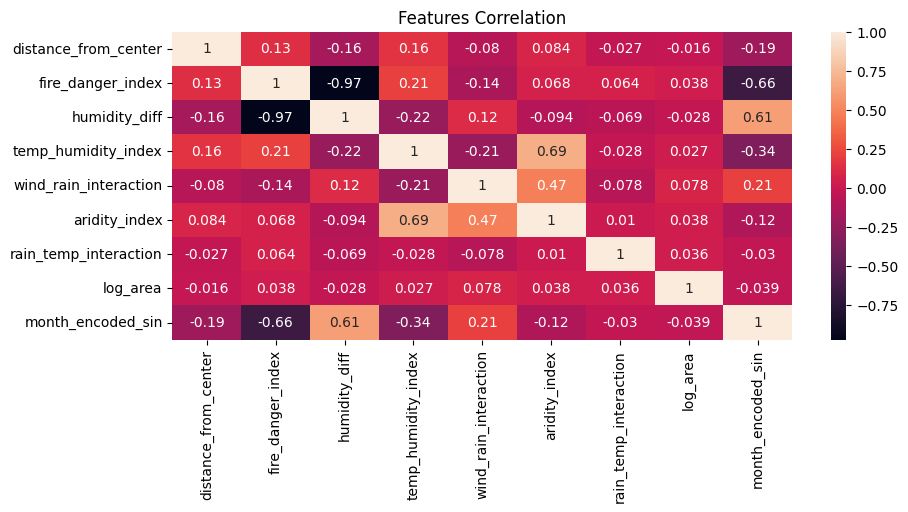

In [16]:
# Creazione delle nuove feature

df_clean_new = df_clean.copy()

# 1. Coordinate spaziali
X_center, Y_center = 5, 5
df_clean_new['distance_from_center'] = np.sqrt((df_clean_new['X'] - X_center)**2 + (df_clean_new['Y'] - Y_center)**2)

# 3. Indici del sistema di pericolo d'incendio
df_clean_new['fire_danger_index'] = df_clean_new['FFMC'] * df_clean_new['ISI'] + df_clean_new['DMC'] * df_clean_new['DC']
df_clean_new['humidity_diff'] = df_clean_new['FFMC'] - df_clean_new['DMC']

# 4. Condizioni meteorologiche
df_clean_new['temp_humidity_index'] = df_clean_new['temp'] * (100 - df_clean_new['RH'])
df_clean_new['wind_rain_interaction'] = df_clean_new['wind'] * (1 - df_clean_new['rain'] / 6.4)
df_clean_new['aridity_index'] = df_clean_new['temp'] * (1 - df_clean_new['RH']/100) * df_clean_new['wind']

# 5. Raggruppamento temporale
df_clean_new['rain_temp_interaction'] = df_clean_new['rain'] * df_clean_new['temp']

# Selezione delle feature da mantenere (esempio)
features = [ 'distance_from_center', 'fire_danger_index', 'humidity_diff', 
            'temp_humidity_index', 'wind_rain_interaction', 'aridity_index','rain_temp_interaction', 'log_area', 'month_encoded_sin']

# Seleziona solo le colonne create
df_new = df_clean_new[features]
df_new

plt.figure(figsize=(10,4))
plt.title('Features Correlation')

sns.heatmap(df_new.corr(), annot=True) # Usa la correlazione di Pearson

L'approccio non è andato a buon fine...
5) Dopo gli scarsi risultati ottenuti con i diversi approcci si puo pensare che il dataset non sia adatto a prevedere tutti i tipi di incendi, ma solo quelli piu piccoli, inoltre usiamo il nuovo dataset ingegnerizzato precedentemente.

In [22]:
# Copia del DataFrame originale, per non alterarlo direttamente
df_new_smallFires = df_clean.copy()

small_fire_threshold = 1.0 # Logaritmico

df_new_smallFires = df_new_smallFires[(df_new_smallFires['log_area'] < small_fire_threshold)]

print(f"Dimensione originale del DataFrame: {df_clean.shape}")
print(f"Dimensione del DataFrame con threshold: {df_new_smallFires.shape}")
print(f"dataset ridotto a incendi di dimensioni <= {(np.exp(small_fire_threshold) - 1) / 100} km^2")


df_new_smallFires

Dimensione originale del DataFrame: (506, 12)
Dimensione del DataFrame con threshold: (297, 12)
dataset ridotto a incendi di dimensioni <= 0.01718281828459045 km^2


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
508,1,2,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.000000,-0.866025
510,6,5,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.357674,-0.866025
511,8,6,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.000000,-0.866025
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025


Come prima cosa si può provare ad effettuareuna regressione lineare, provando a vedere se esiste una relazione lineare tra le caratteristiche e l'output

In [24]:
# LINEAR REGRESSOR

X = df_new_smallFires.drop(['log_area'], axis=1)  # Features
y = df_new_smallFires['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni  sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred)

R²: -0.13098524185123117
Train R²: 0.09233900244651227
------------
Mean Absolute Error: 0.21352356689153826 -> km^2 = 0.00238032674506049
Train error (MAE): 0.17440595073441148
------------
Mean Squared Error: 0.09020134219010018
Root Mean Squared Error: 0.30033538284740974 -> km^2 = 0.0035031160299215268
51 / 60 of y_test is 0
------------
aaaaaaaAccuracy in percentage (with a tolerance of 5%): 80.00%
aaaaaaaAccuracy in percentage (with a tolerance of 10%): 90.00%
aaaaaaaAccuracy in percentage (with a tolerance of 30%): 100.00%
aaaaaaaAccuracy in percentage (with a tolerance of 100%): 100.00%


L'accuratezza del linear regressor non è buona... Un approccio con support vector machines potrebbe essere una scelta opportuna per cercare relazioni non lineari tra le caratteristiche e la variabile di output. Questo approccio, tramite una funzione kernel, trasforma e mappa i dati in un nuovo spazio al fine di trovare pattern rilevanti nei dati (funzione kernel utilizzata: rbf)

In [23]:
# SVM

X = df_new_smallFires.drop(['log_area', 'month_encoded_sin'], axis=1)  # Features
y = df_new_smallFires['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = SVR(kernel='rbf')
#model.fit(X_train, y_train)

# Parametri da esplorare con GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Penalità dell'errore
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Flessibilità del kernel RBF
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)


# Valutazione performace
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred)

Best parameters: {'C': 0.1, 'gamma': 1}
R²: -0.003688996684446
Train R²: 0.2695000060864662
------------
Mean Absolute Error: 0.19480019261564033 -> km^2 = 0.0021506818263814574
Train error (MAE): 0.1582932510663109
------------
Mean Squared Error: 0.08004887357697353
Root Mean Squared Error: 0.2829290963774732 -> km^2 = 0.0032701106858952513
51 / 60 of y_test is 0
------------
aaaaaaaAccuracy in percentage (with a tolerance of 5%): 86.67%
aaaaaaaAccuracy in percentage (with a tolerance of 10%): 90.00%
aaaaaaaAccuracy in percentage (with a tolerance of 30%): 100.00%
aaaaaaaAccuracy in percentage (with a tolerance of 100%): 100.00%


Proviamo ora con una rete neurale

In [20]:
# NN 
X = df_clean.drop(['log_area'], axis=1)  # Features
y = df_clean['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred)

R²: -0.0924806534855589
Train R²: 0.14238719468310101
------------
Mean Absolute Error: 1.0499078901236636 -> km^2 = 0.01857387912294178
Train error (MAE): 0.9932092310134742
------------
Mean Squared Error: 1.4510341479158284
Root Mean Squared Error: 1.204588787892295 -> km^2 = 0.02335387244410654
57 / 102 of y_test is 0
------------
aaaaaaaAccuracy in percentage (with a tolerance of 5%): 6.86%
aaaaaaaAccuracy in percentage (with a tolerance of 10%): 16.67%
aaaaaaaAccuracy in percentage (with a tolerance of 30%): 85.29%
aaaaaaaAccuracy in percentage (with a tolerance of 100%): 100.00%


In [21]:
# GRADIENT BOOST REGRESSION
X = df_clean.drop(['log_area', 'month_encoded_sin'], axis=1)
#X = df[['temp', 'RH', 'wind', 'rain']]
y = df_clean['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Parametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300, 500],        # Numero di alberi
    'learning_rate': [0.01, 0.1, 0.2],     # Velocità di apprendimento
    'max_depth': [3, 5, 7, 10],                # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],       # Minimo numero di campioni per split
    'min_samples_leaf': [1, 2, 4],         # Minimo numero di campioni in una foglia
}

# Grid Search con validazione incrociata
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit dei dati di addestramento
grid_search.fit(X_train, y_train)

# Miglior modello
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 